In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [2]:
def setup_logging(fits_file, initial_message=None):
    # Extract the directory and base name from the FITS file path
    original_dir = os.path.dirname(fits_file) # Get the ObsID folder
    #base_name = os.path.basename(fits_file).replace('.lc', '')  # Remove the .evt extension
    base_name = os.path.basename(fits_file).replace('.evt', '')  # Remove the .evt extension
    
    # Define the log file path and plot file path in the ObsID folder
    log_file_path = os.path.join(original_dir, f"{base_name}_orbit_evt.log")
    plot_file_path= os.path.join(original_dir, f"{base_name}_orbit_evt.png")
    #log_file_path = os.path.join(original_dir, f"{base_name}_orbit_lc.log")
    #plot_file_path= os.path.join(original_dir, f"{base_name}_orbit_lc.png")
    
    # Overwrite log file each time and write the initial message if provided
    with open(log_file_path, 'w') as log_file:
        if initial_message:
            log_file.write(f"{initial_message}\n")
    
    return log_file_path,plot_file_path

def write_log_message(log_file_path, message):
    with open(log_file_path, 'a') as log_file:  # Open in append mode
        log_file.write(f"{message}\n")

In [3]:
def find_event_files(base_directory):
    event_files = []
    
    # Regular expression to match the pattern ObsID/xti/event_cl/
    obsid_pattern = re.compile(r'^\d{10}$')
    #obsid_pattern = re.compile(r'^\d{10}/xti/event_cl/$')
    #For one file
    #obsid_pattern = re.compile(r'6050390244/xti/event_cl/$')
    
    # Regular expressions to match the specific filename patterns
    file_pattern = re.compile(r'^ni\d{10}_0mpu7_cl_(night|daynotconsidered)_barycorr.evt$')
    #file_pattern = re.compile(r'^ni\d{10}_cl_(night|day)mpu7_sr_night_barycorr.lc$')

    #########################################################################
    ##############**WRITING For Experiment orbital file structure**##########
    # ###################################################################### 

    # # Walk through the directory tree
    # for root, dirs, files in os.walk(base_directory):
    #     # Extract relative path from the base directory
    #     rel_path = os.path.relpath(root, base_directory)
        
    #     # Check if the relative path matches the pattern
    #     if obsid_pattern.match(rel_path + '/'):
    #         # Collect all files in this directory
    #         for file in files:
    #             # Check if the file matches the required patterns
    #             if file_pattern.match(file):
    #                 full_path = os.path.join(root, file)
    #                 event_files.append(full_path)
    #                 #print(full_path)
    #             # else:
    #             #     print(f"Ignored file: {file} in directory: {rel_path}")
    
    # return event_files
    # Iterate through subdirectories in the base directory


    for obsid_dir in os.listdir(base_directory):
        obsid_path = os.path.join(base_directory, obsid_dir)

        # Check if it's a directory and matches the 10-digit ObsID pattern
        if os.path.isdir(obsid_path) and obsid_pattern.match(obsid_dir):
            #print(f"Found 10-digit ObsID folder: {obsid_dir}")

            # Look for files in this directory matching the .evt pattern
            for file in os.listdir(obsid_path):
                if file_pattern.match(file):
                    full_path = os.path.join(obsid_path, file)
                    event_files.append(full_path)
                    #print(f"Found .evt file: {full_path}")

    return event_files

In [4]:
# Orbital parameters provided
a_sin_i = 115.531  # Semi-major axis in light-seconds
P_orb = 27.6943  # Orbital period in days
e = 0.1029  # Eccentricity
omega = -74.05 # Longitude of periastron in radians
T_pi2 = 58116.097  # T_pi/2 in seconds 

In [5]:
def extract_fits_info(fits_file, log_file_path):
    with fits.open(fits_file) as hdul:
        header = hdul[1].header
        mjdrefi = header['MJDREFI']
        mjdreff = header['MJDREFF']
        leap_seconds = header.get('TIMEZERO', -1)  # Default to 0 if TIMEZERO not present
        met = np.array(hdul[1].data['BARYTIME'],dtype=np.float128)  # Assuming MET is stored in the 'TIME' column
        #met = np.array(hdul[1].data['TIME'],dtype=np.float128)  # Assuming MET is stored in the 'TIME' column
    
    print("Debugging extract step")
    write_log_message(log_file_path, f"Extracted MET and header info from {fits_file}")
    return met, mjdrefi, mjdreff, leap_seconds

# Step 2: Convert MET to Modified Julian Date (MJD)
def convert_met_to_mjd(met, mjdrefi, mjdreff, leap_seconds, log_file_path):
    met = np.float128(met)
    mjdrefi = np.float128(mjdrefi)
    mjdreff = np.float128(mjdreff)
    leap_seconds = np.float128(leap_seconds)
    # Perform the conversion to MJD
    met_in_days = met / np.float128(86400.0)
    mjd = met_in_days + mjdrefi + mjdreff + (leap_seconds / np.float128(86400.0))
    print("Debugging convert step")
    write_log_message(log_file_path, f"Converted MET to MJD: {mjd}")
    return mjd

# Step 3: Calculate Mean Anomaly M
def calculate_mean_anomaly(mjd, T_pi2, P_orb, log_file_path):
    # Convert inputs to np.float128 for higher precision
    mjd = np.float128(mjd)
    T_pi2 = np.float128(T_pi2)
    P_orb = np.float128(P_orb)
    t0 = T_pi2+(omega-90.)/360. * P_orb
    # Calculate Mean Anomaly with high precision
    tper = (mjd-t0)/P_orb
	# Calculate the mean anomaly
    mean_anomaly = 2 * np.pi * (tper*1.)
    # Normalize m to the range [0, 2π]
    mean_anomaly = mean_anomaly % (2 * np.pi)

	# Shift m to the range [-π, π] if needed
    mean_anomaly[mean_anomaly > np.pi] -= 2 * np.pi

    print("Debugging mean anomaly step")
    # print("MJD: ",mjd)
    # print("Mean Anomaly:", mean_anomaly)
    # print("T_pi2: ", T_pi2)
    # Log the result
    write_log_message(log_file_path, f"Calculated Mean Anomaly: {mean_anomaly}")
    return mean_anomaly

# Step 4: Compute Eccentric Anomaly E using Mikkola's cubic approximation variable s
def compute_eccentric_anomaly_proxy(mean_anomaly, e, log_file_path):
    # Convert inputs to np.float128 for higher precision
    mean_anomaly = np.float128(mean_anomaly)
    e = np.float128(e)
    
    # Compute alpha and beta with high precision
    alpha = (1 - e) / (4 * e + np.float128(0.5))
    beta = np.float128(0.5) * mean_anomaly / (4 * e + np.float128(0.5))
    
    # Calculate the cubic root terms with high precision
    z = np.where(
        beta >= 0,
        np.float128(np.cbrt(beta + np.sqrt(beta**2 + alpha**3))),
        np.float128(np.cbrt(beta - np.sqrt(beta**2 + alpha**3)))
    )  
    # Compute the proxy for the eccentric anomaly
    s = z - alpha / z
    print("Debugging proxy eccentric step")
    # Log the result
    write_log_message(log_file_path, f"Computed Eccentric Anomaly Proxy: {s}")
    return s

# Step 5: Incorporate error term as done in Mikkola 1987
def correct_eccentric_anomaly(mean_anomaly, s, e, log_file_path):
    # Convert inputs to np.float128 for higher precision
    mean_anomaly = np.float128(mean_anomaly)
    s = np.float128(s)
    e = np.float128(e)
    # Calculate the correction term ds with high precision
    ds = (-0.078 * s**5) / (1 + e)
    s_true = s + ds
    # Calculate the corrected eccentric anomaly
    eccentric_anomaly = mean_anomaly + e * (3 * s_true - 4 * s_true**3)
    print("Debugging corrected eccentric step")
    # Log the result
    write_log_message(log_file_path, f"Corrected Eccentric Anomaly: {eccentric_anomaly}")
    return eccentric_anomaly

# Step 6: Calculate Rømer time delay for the binary system
def calculate_romer_delay(eccentric_anomaly, e, a_sin_i, omega, log_file_path):
    # Convert inputs to np.float128 for higher precision
    eccentric_anomaly = np.float128(eccentric_anomaly)
    e = np.float128(e)
    a_sin_i = np.float128(a_sin_i)
    omega = np.float128(omega)
    # Calculate sine and cosine terms with high precision
    sin_E = np.sin(eccentric_anomaly)
    cos_E = np.cos(eccentric_anomaly)
    # Compute the Rømer delay
    romer_delay = a_sin_i * ((cos_E - e) * np.sin(omega) + 
                             np.sqrt(1 - e**2) * sin_E * np.cos(omega))
    
    print("Debugging romer delay step")
    # Log the result
    write_log_message(log_file_path, f"Calculated Rømer Delay: {romer_delay}")
    return romer_delay

# Step 7: Correct Event Timestamp
def correct_event_timestamp(met, romer_delay, log_file_path):
    # Convert inputs to np.float128 for higher precision
    met = np.float128(met)
    romer_delay = np.float128(romer_delay)
    # Correct the event timestamp
    corrected_timestamp = met - romer_delay
    # Log the result
    print("Debugging timestamp step")
    write_log_message(log_file_path, f"Corrected Event Timestamp: {corrected_timestamp}")
    return corrected_timestamp

In [6]:
def write_corrected_fits(original_fits, corrected_timestamps, log_file_path):
    
    # Extract the base name and directory from the original FITS file
    base_name = os.path.basename(original_fits)
    original_dir = os.path.dirname(original_fits)  # Get the directory of the original file
    
    # Construct the new filename for the corrected FITS file
    new_file = os.path.join(original_dir, base_name.replace('.evt', '_orbit.evt'))
    #new_file = os.path.join(original_dir, base_name.replace('.lc', '_orbit.lc'))
    try:
        # Modify the 'TIME' column with corrected timestamps
        with fits.open(original_fits, mode='readonly') as hdul:
            # Extract necessary values from the header
            MJDREFI = hdul[1].header['MJDREFI']
            MJDREFF = hdul[1].header['MJDREFF']
            TIMEZERO = hdul[1].header['TIMEZERO']

            # Combine MJDREFI and MJDREFF to get the full MJDREF
            MJDREF = MJDREFI + MJDREFF

            # Convert the MJD timestamps to MET using the formula from TIME definition NICER thread
            corrected_met = (corrected_timestamps - MJDREF) * 86400 - TIMEZERO
            
            # Ensure the data is mutable
            hdul[1].data['TIME'] = corrected_met
            
            # Write the new FITS file in the same directory
            hdul.writeto(new_file, overwrite=True)
        
        write_log_message(log_file_path, f"Corrected FITS file saved as {new_file}")
        
    except Exception as e:
        write_log_message(log_file_path, f"Failed to write corrected FITS file {new_file}: {str(e)}")
        print(f"Error saving corrected FITS file: {str(e)}")


In [7]:
def main(base_directory, T_pi2, P_orb, e, a_sin_i, omega):
    event_files = find_event_files(base_directory)
    input_times = []
    corrected_times = []

    for fits_file in event_files:
        log_file_path,plot_file_path = setup_logging(fits_file)  # Setup logging and get log file path
        write_log_message(log_file_path, f"Processing file: {fits_file}")
        #print(event_files)
        try:
            # Step 1: Extract info from the FITS file
            met, mjdrefi, mjdreff, leap_seconds = extract_fits_info(fits_file,log_file_path)
            write_log_message(log_file_path, f"Extracted MET and header info from {fits_file}")
            # Step 2: Convert MET to MJD
            mjd = convert_met_to_mjd(met, mjdrefi, mjdreff, leap_seconds,log_file_path)
            write_log_message(log_file_path, f"Converted MET to MJD for {fits_file}")

            # Step 3: Calculate Mean Anomaly
            mean_anomaly = calculate_mean_anomaly(mjd, T_pi2, P_orb,log_file_path)
            write_log_message(log_file_path, f"Calculated Mean Anomaly for {fits_file}")
            print("Mean anomaly: ",mean_anomaly)
            # Step 4: Compute Eccentric Anomaly
            s = compute_eccentric_anomaly_proxy(mean_anomaly, e,log_file_path)
            write_log_message(log_file_path, f"Computed Eccentric Anomaly Proxy for {fits_file}")

            # Step 5: Correct Eccentric Anomaly
            corrected_eccentric_anomaly = correct_eccentric_anomaly(mean_anomaly, s, e,log_file_path)
            write_log_message(log_file_path, f"Corrected Eccentric Anomaly for {fits_file}")
            print("Ecc anomaly: ",corrected_eccentric_anomaly)
            # Step 6: Calculate Rømer delay
            romer_delay = calculate_romer_delay(corrected_eccentric_anomaly, e, a_sin_i, omega,log_file_path)
            write_log_message(log_file_path, f"Calculated Rømer delay for {fits_file}")

            # Step 7: Correct Event Timestamps
            corrected_timestamps = correct_event_timestamp(met, romer_delay,log_file_path)
            write_log_message(log_file_path, f"Corrected event timestamps for {fits_file}")
            print("Original: ",met)
            print("Corrected: ",corrected_timestamps)

            # Store only the first and last timestamps
            input_times.extend([met[0], met[-1]])
            corrected_times.extend([corrected_timestamps[0], corrected_timestamps[-1]])

            # Write the corrected FITS file
            write_corrected_fits(fits_file, corrected_timestamps, log_file_path)  # Pass log_file_path here
            write_log_message(log_file_path, f"Successfully processed {fits_file}")

            #Save the delta plot
            plt.plot(mjd,met-corrected_timestamps)
            plt.savefig(plot_file_path)
            plt.close()
            
            print('successful for: ',fits_file)

        except Exception as e:
            write_log_message(log_file_path, f"Error processing {fits_file}: {str(e)}")

     # Convert lists to numpy arrays
    input_times_array = np.array(input_times)
    corrected_times_array = np.array(corrected_times)

    # Save the arrays to an NPZ file
    np.savez("evt_corrected_time.npz", input_times=input_times_array, corrected_times=corrected_times_array)
    print("Times saved successfully")


In [9]:
# Example usage
base_directory = './reduced_output'  # Change to your base directory
main(base_directory, T_pi2, P_orb, e, a_sin_i, omega)

['./reduced_output/6050390261/ni6050390261_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390212/ni6050390212_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390240/ni6050390240_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390251/ni6050390251_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390249/ni6050390249_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390230/ni6050390230_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390206/ni6050390206_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390223/ni6050390223_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390243/ni6050390243_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390204/ni6050390204_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390242/ni6050390242_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390272/ni6050390272_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390271/ni6050390271_0mpu7_cl_night_barycorr.evt', './reduced_output/6050390254/ni6050390254_0mpu7_cl_night_baryco

## Plotting delays for all the observations

In [12]:
import numpy as np
import matplotlib.pyplot as plt
data=np.load("evt_corrected_time_piexpiex.npz")

In [13]:
input=np.sort(data['input_times'])
corrected=np.sort(data['corrected_times'])

In [16]:
delay= (corrected-input)*86400

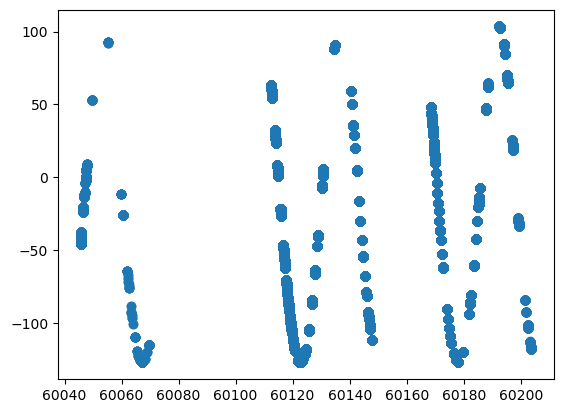

In [17]:
plt.scatter(input[::200],(delay)[::200])

In [10]:
# #***********DEBUGGING READING FILES************#
# base_directory = './'
# event_files = find_event_files(base_directory)
# print("Found event files:")
# for ef in event_files:
#     print(ef)


In [11]:
# #********DEBUGGING MJD TIME **********##
# hdu=fits.open(fits_file)
# hdu[1].data['TIME']+hdu[1].header['MJDREFI']+hdu[1].header['MJDREFF']+hdu[1].header['LEAPINIT']